In [2]:
import numpy as np
import scipy.signal, scipy.io
import matplotlib.pyplot as plt

In [3]:
FS = 51200

def load_mat(filename):
    mat = scipy.io.loadmat(filename, simplify_cells=True)
    data = mat["Final"]
    return data

# structure:
# Final.Data = Data; # contient "Time" qui est la même chose que Final.time
# Final.marteau.fen = signal_marteau_fen;
# Final.accelero.fen = signal_accelero_fen;
# Final.marteau.brut = signal_marteau;
# Final.accelero.brut = signal_accelero;
# Final.FRF = FRF(1:Nfft/2);
# Final.freq = freq;
# Final.time = time;

def plot_data(data, title, fmax):
    fig, axs = plt.subplots(4)
    fig.set_size_inches(10,10)
    fig.suptitle(title)

    def plot_response(ax, name, data, marge, epsilon):
        x = data[name]["fen"]
        ax.set_title(name)

        start = np.min((np.abs(x) > epsilon).nonzero()) - int(marge*FS)
        end = np.max((np.abs(x) > epsilon).nonzero()) + int(marge*FS)

        ax.plot(data["time"][start:end], data[name]["fen"][start:end])

    plot_response(axs[0], "marteau", data, 0.001, 0.05)
    plot_response(axs[1], "accelero", data, 0.001, 1)

    domaine = data["freq"] < fmax
    axs[2].set_title("FRF (dB)")
    axs[2].plot(data["freq"][domaine], 20*np.log(np.abs(data["FRF"][domaine])))
    axs[3].set_title("Phase (rad)")
    axs[3].plot(data["freq"][domaine], np.angle(data["FRF"][domaine]))
    return fig, axs

(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: title={'center': 'marteau'}>,
        <Axes: title={'center': 'accelero'}>,
        <Axes: title={'center': 'FRF (dB)'}>,
        <Axes: title={'center': 'Phase (rad)'}>], dtype=object))

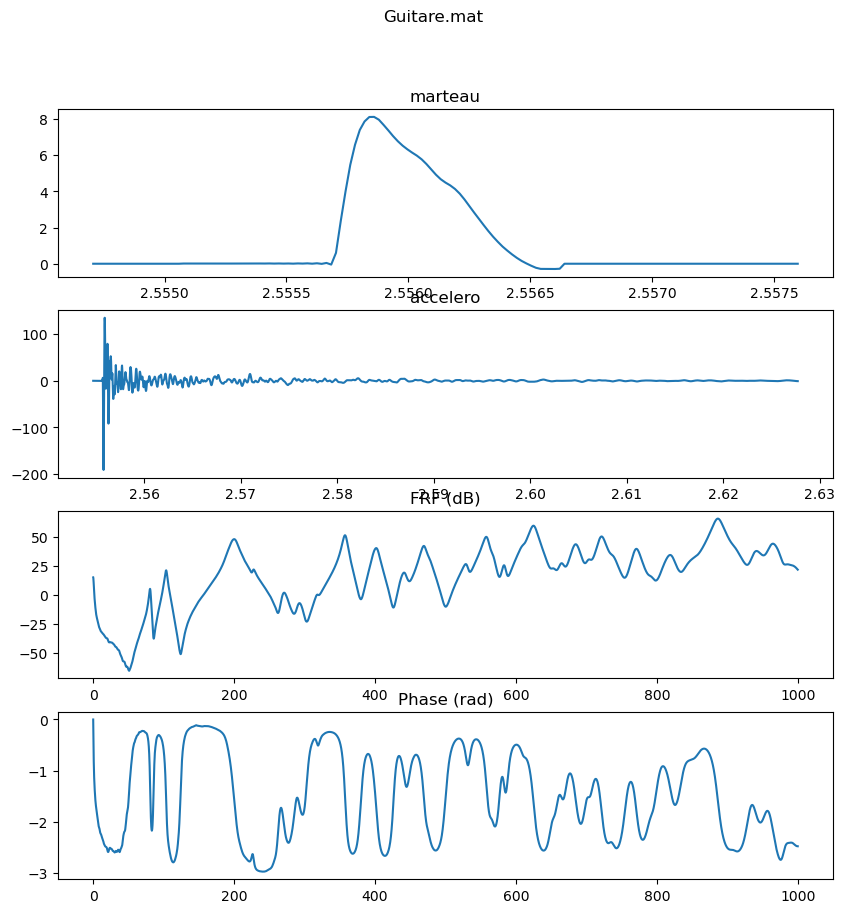

In [4]:
filename = "Guitare.mat"
data = load_mat(filename)
plot_data(data, filename, 1000)

In [5]:
fmax = 600
domaine = data["freq"] < fmax

freq = data["freq"][domaine]
frf = data["FRF"][domaine]
phase = np.angle(data["FRF"][domaine])
mag = 20 * np.log(abs(data["FRF"][domaine]))

def trouver_pics(freq, mag, phase,plot=False):
    i_pisur2 = np.where(np.diff(np.sign(phase + np.pi/2)))[0]
    if plot:
        plt.plot(freq, mag)
        plt.plot(freq[i_pisur2], mag[i_pisur2], 'x')
        plt.show()
    return i_pisur2

def get_delta_f(f, f_zone, plot=False):
    domaine = np.abs(freq-f) < f_zone

    i_max = np.argmax(mag[domaine])
    f_max = freq[domaine][i_max]
    mag_max = mag[domaine][i_max]

    i_zone = np.where(np.diff(np.sign(mag[domaine] - mag_max +3)))[0]
    if len(i_zone) != 2:
        print("oh no")
        return
    i_moins, i_plus = i_zone
    i_plus += 1
    f_moins, f_plus = freq[domaine][i_moins], freq[domaine][i_plus]
    mag_moins, mag_plus = mag[domaine][i_moins], mag[domaine][i_plus]
    delta_f = f_plus - f_moins
    if plot:
        plt.plot(freq[domaine], mag[domaine])
        plt.plot(f_max, mag_max, 'x')
        plt.plot([f_moins, f_plus], [mag_moins, mag_plus])
        plt.show()
    print(f"f_max={f_max:.2} Hz, mag_max={mag_max:.2} dB, delta f (-3db) = {delta_f:.2} Hz")
    return delta_f

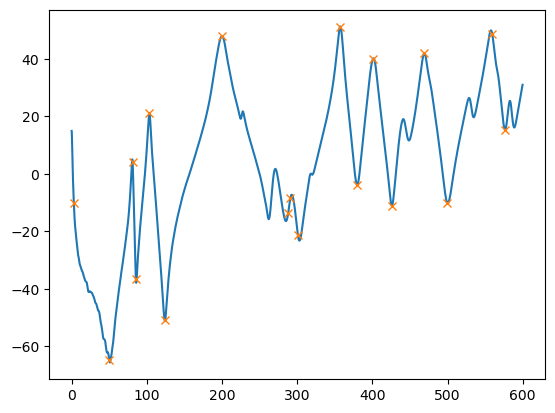

In [6]:
i_pics = trouver_pics(freq, mag, phase, plot=True)

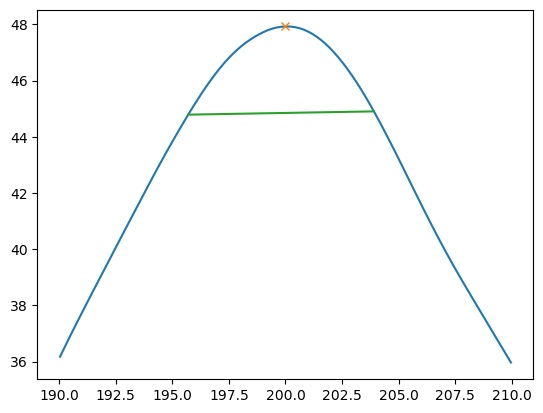

f_max=2e+02 Hz, mag_max=4.8e+01 dB, delta f (-3db) = 8.2 Hz


8.203125

In [7]:
get_delta_f(200, 10, True)

In [8]:
def trouver_pics(freq, mag, phase,color="blue",plot=False):
    i_pisur2 = np.where(np.diff(np.sign(phase + np.pi/2)))[0]
    if plot:
        #plt.plot(freq, mag)
        plt.plot(freq[i_pisur2], mag[i_pisur2], 'x',color=color)
    return i_pisur2

In [9]:
def get_delta_f(file,f, f_zone):
    data = load_mat(file)
    
    domaine = np.abs(data["freq"]-f) < f_zone

    freq = data["freq"][domaine]
    mag = 20*np.log(np.abs(data["FRF"]))[domaine]
    

    i_max = np.argmax(mag)
    f_max = freq[i_max]
    mag_max = mag[i_max]

    i_zone = np.where(np.diff(np.sign(mag - mag_max +3)))[0]
    if len(i_zone) != 2:
        raise Exception
    i_moins, i_plus = i_zone
    i_plus += 1
    f_moins, f_plus = freq[i_moins], freq[i_plus]

    delta_f = f_plus - f_moins
    return delta_f,f_max/delta_f


In [10]:
def file2text(file):
    filesplit = file.split("_")[:-1]
    return ' '.join(filesplit).capitalize()

In [11]:
import os
import pandas as pd

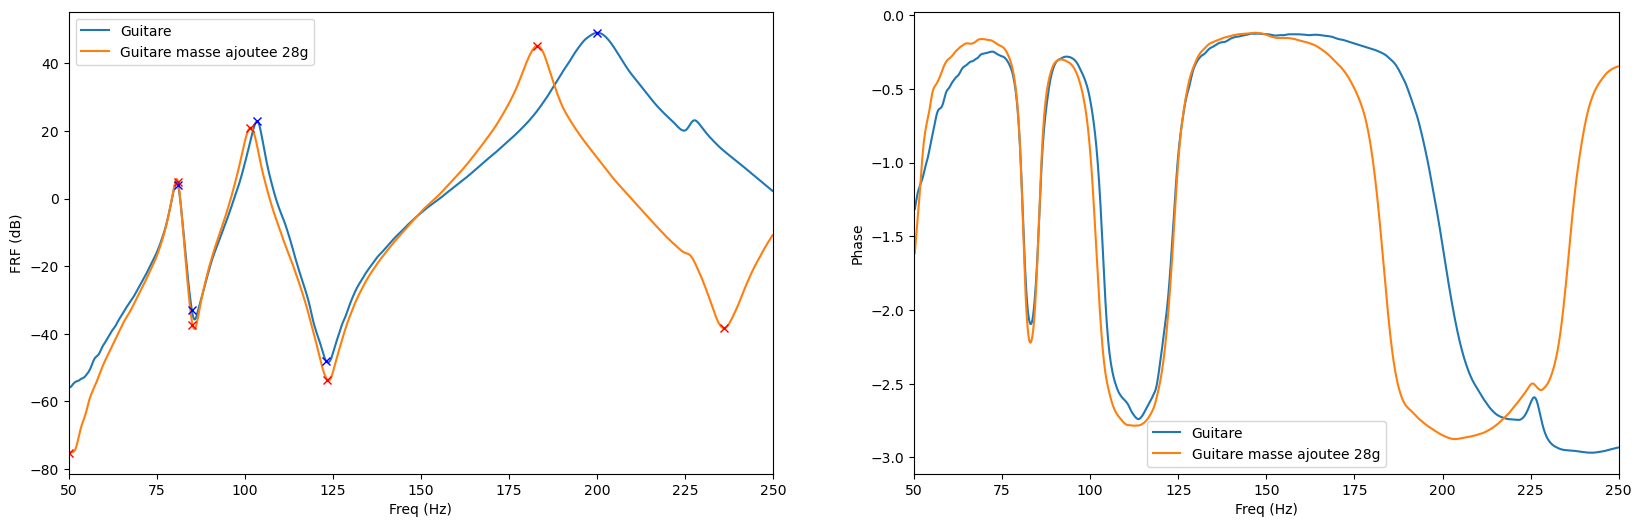

Pics Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics Guitare masse ajoutee 28g:[ 50.1953125  81.0546875  85.15625   101.5625    123.4375    182.8125
 235.9375   ]


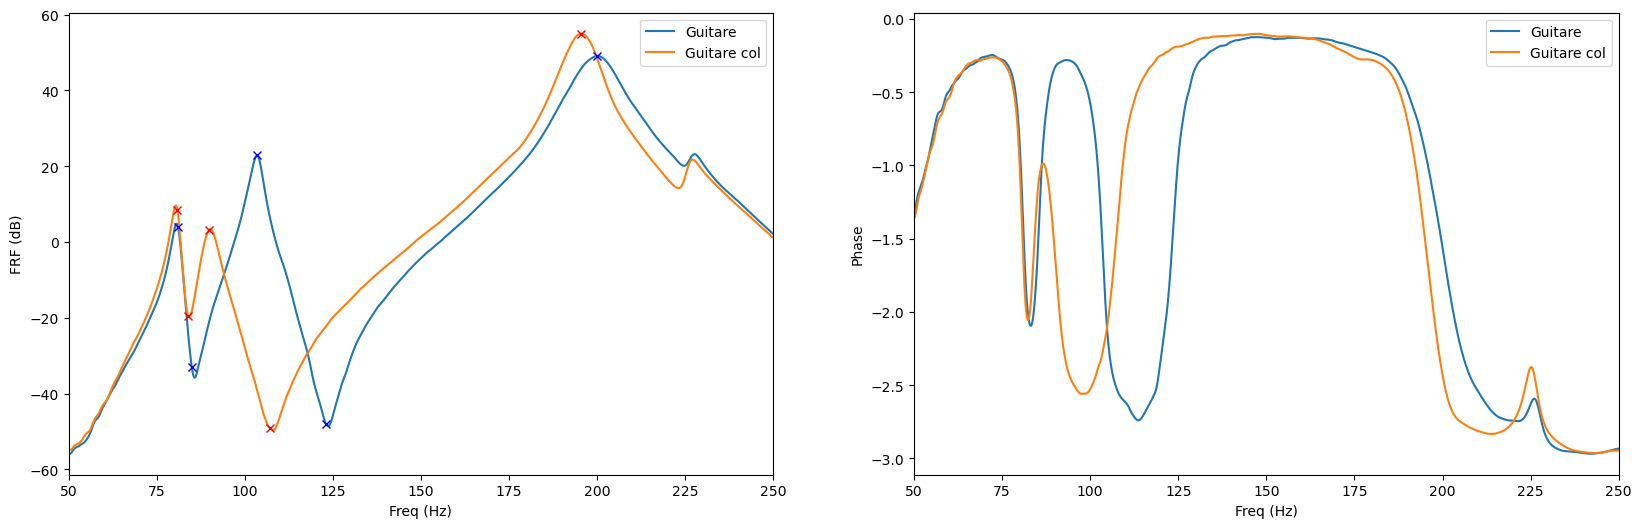

Pics Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics Guitare col:[ 80.859375  83.984375  89.84375  107.03125  195.3125  ]


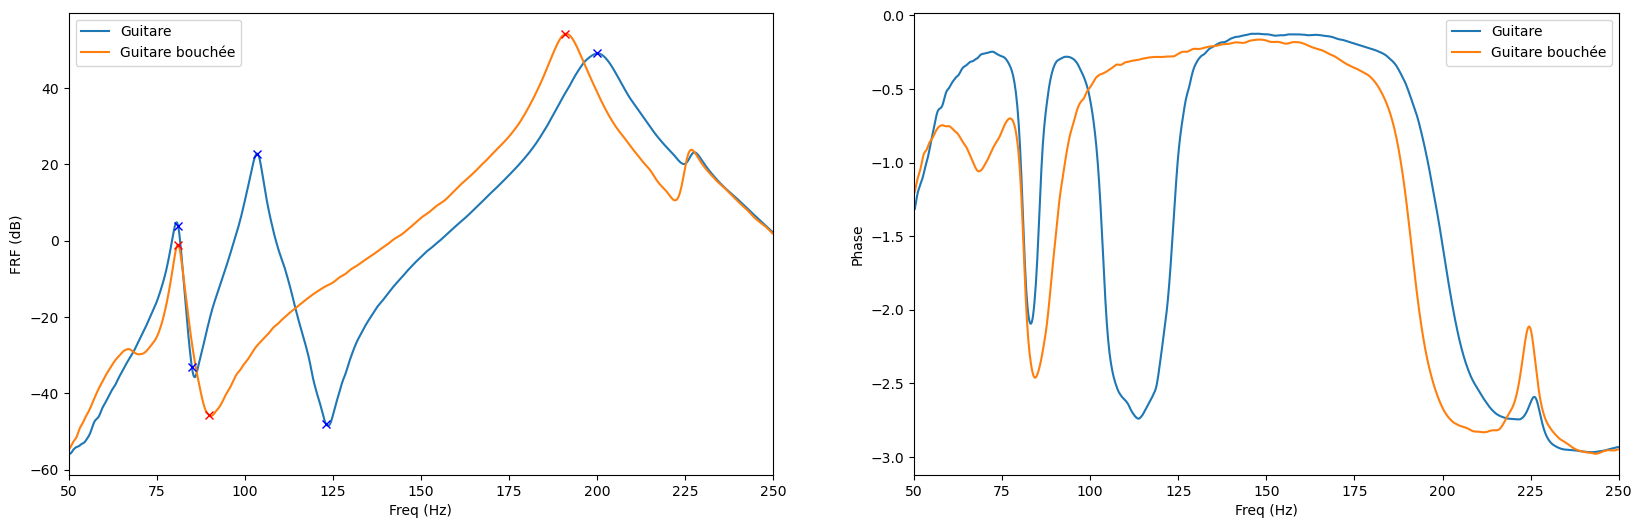

Pics Guitare:[ 81.0546875  84.9609375 103.515625  123.046875  200.       ]
Pics Guitare bouchée:[ 81.0546875  89.84375   191.015625 ]


In [12]:
def compare(file1,file2,freqmin=50,freqmax=250,freqvert = 87):
    data1 = load_mat(file1)
    data2 = load_mat(file2)

    domaine = np.logical_and(data["freq"] < freqmax ,data["freq"] > freqmin )

    freq1 = data1["freq"][domaine]
    mag1 = 20*np.log(np.abs(data1["FRF"]))[domaine]
    phase1 = np.angle(data1["FRF"])[domaine]
    
    freq2 = data2 ["freq"][domaine]
    mag2 = 20*np.log(np.abs(data2["FRF"]))[domaine]
    phase2 = np.angle(data2["FRF"])[domaine]
    
    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.xlim([freqmin,freqmax])

    plt.plot(freq1,mag1,label = file2text(file1))
    plt.plot(freq2,mag2,label = file2text(file2))
    
    pics1 = trouver_pics(freq1,mag1,phase1,color="blue",plot=True)
    pics2 = trouver_pics(freq2,mag2,phase2,color="red",plot=True)

    #plt.axvline(x=freqvert,color="green")
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FRF (dB)")
    plt.legend()

    plt.subplot(1,2,2)

    plt.xlim([freqmin,freqmax])
    plt.plot(freq1,phase1,label = file2text(file1))
    plt.plot(freq2,phase2,label = file2text(file2))

    plt.xlabel("Freq (Hz)")
    plt.ylabel("Phase")
    plt.legend()

    plt.savefig(os.path.join('images',file2text(file2)))
    
    plt.show()
    
    print(f"Pics {file2text(file1)}:{freq1[pics1]}\nPics {file2text(file2)}:{freq2[pics2]}")

    return freq1[pics1],freq2[pics2]

#pics_normal, pics_20g = compare("Guitare_2.mat","Guitare_masse_ajoutee_20g_2.mat")
pics_normal, pics_28g = compare("Guitare_2.mat","Guitare_masse_ajoutee_28g_3.mat")
pics_normal, pics_col = compare("Guitare_2.mat","Guitare_col_2.mat")
pics_normal, pics_bouche = compare("Guitare_2.mat","Guitare_bouchée_2.mat")


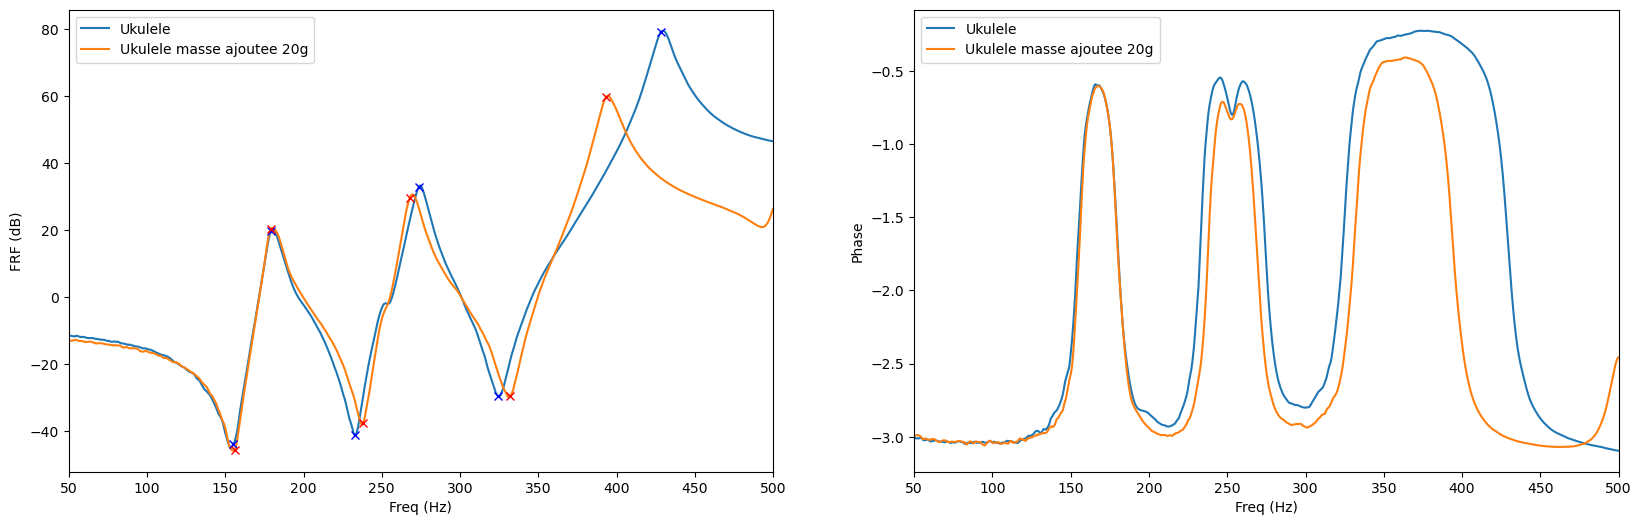

Pics Ukulele:[155.078125  179.296875  233.203125  273.6328125 324.4140625 428.515625 ]
Pics Ukulele masse ajoutee 20g:[156.0546875 179.1015625 238.28125   267.96875   331.640625  393.359375 ]


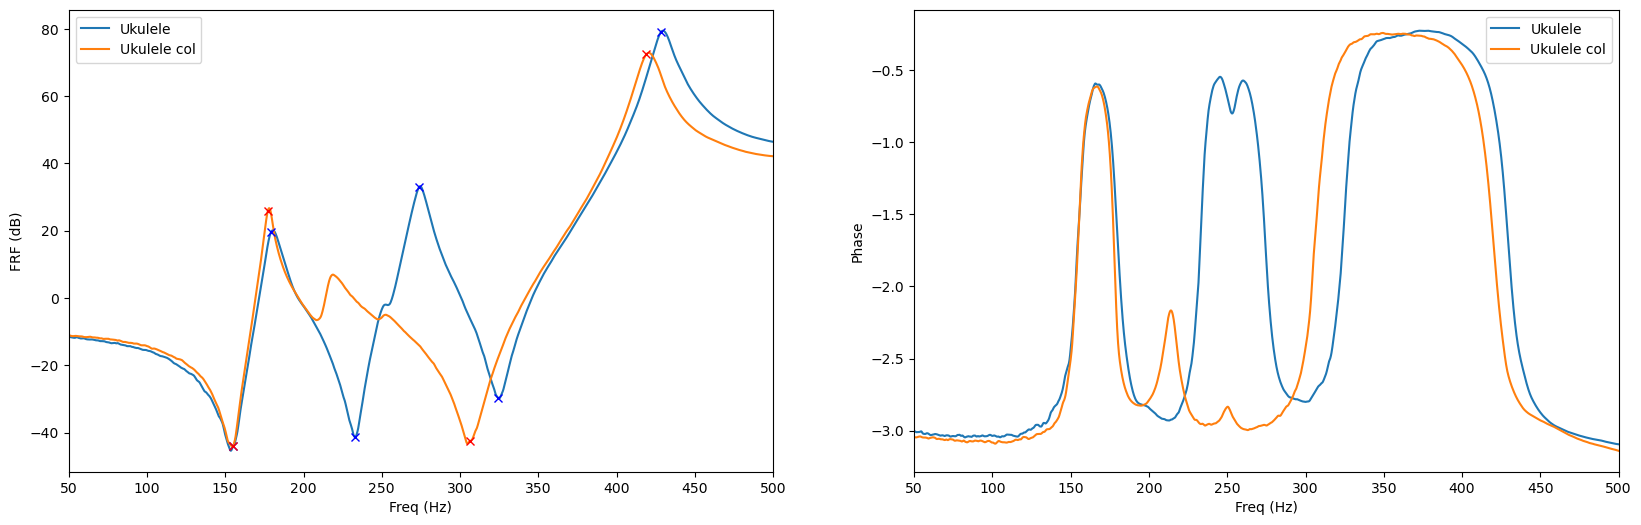

Pics Ukulele:[155.078125  179.296875  233.203125  273.6328125 324.4140625 428.515625 ]
Pics Ukulele col:[155.078125  177.1484375 306.640625  418.9453125]


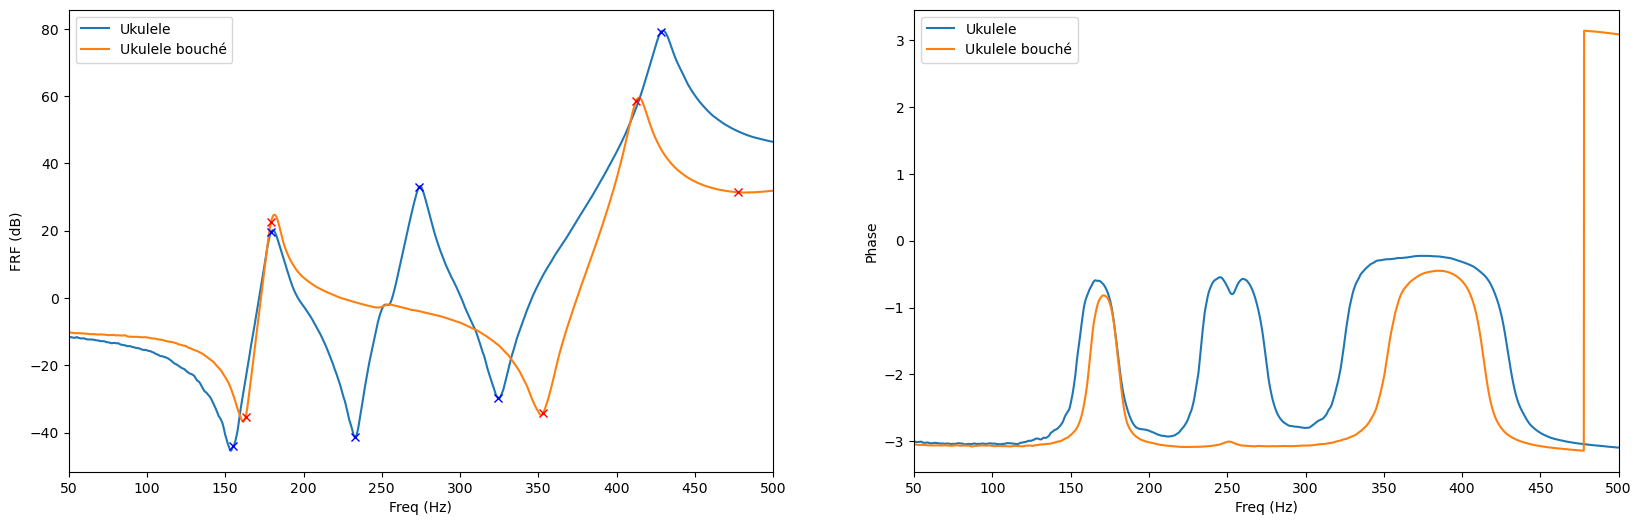

Pics Ukulele:[155.078125  179.296875  233.203125  273.6328125 324.4140625 428.515625 ]
Pics Ukulele bouché:[163.0859375 179.296875  353.125     412.5       477.734375 ]


In [14]:
pics_ukulele, pics_20g_ukulele = compare("Ukulele_2.mat","Ukulele_masse_ajoutee_20g_2.mat",freqmax=500,freqvert=200)
picsl_ukulele, pics_col_ukulele = compare("Ukulele_2.mat","Ukulele_col_3.mat",freqmax=500,freqvert=200) #219
pics_ukulele, pics_bouche_ukulele = compare("Ukulele_2.mat","Ukulele_bouché_2.mat",freqmax=500,freqvert=200)

fmoins=103.5Hz	fh=123.0Hz	fplus=200.0Hz
fp = 188.6Hz	fph = 102.4Hz
fa = 85.2Hz	fp0 = 168.3Hz
fmoinsa=101.6Hz	fha=123.4Hz	fplusa=182.8Hz
Masse de la table d'harmonie : 140.8 g	Raideur de la table d'harmonie : 157.32 kN/m	Aire de piston équivalent : 1.123 m^2
Q_moins=40.77	Q_plus=24.40
gamma_moins=15.95	gamma_plus=51.54
gamma_p=52.15	gamma_a=15.34
A/mp=7.9750588352703815


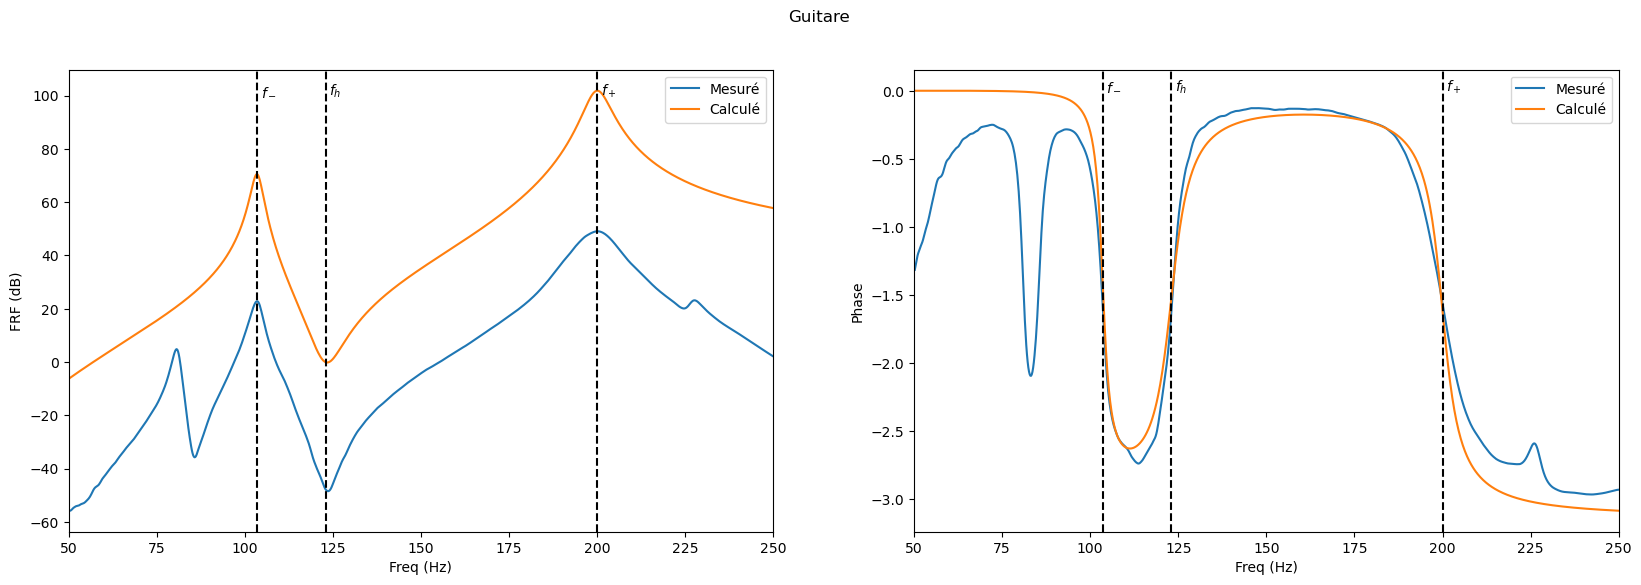

fmoins=273.6Hz	fh=324.4Hz	fplus=428.5Hz
fp = 391.5Hz	fph = 220.9Hz
fa = 150.4Hz	fp0 = 361.4Hz
fmoinsa=268.0Hz	fha=331.6Hz	fplusa=393.4Hz
Masse de la table d'harmonie : 83.5 g	Raideur de la table d'harmonie : 430.70 kN/m	Aire de piston équivalent : 1.197 m^2
Q_moins=46.83	Q_plus=53.63
gamma_moins=36.82	gamma_plus=50.31
gamma_p=49.18	gamma_a=37.95
A/mp=14.330724871055372


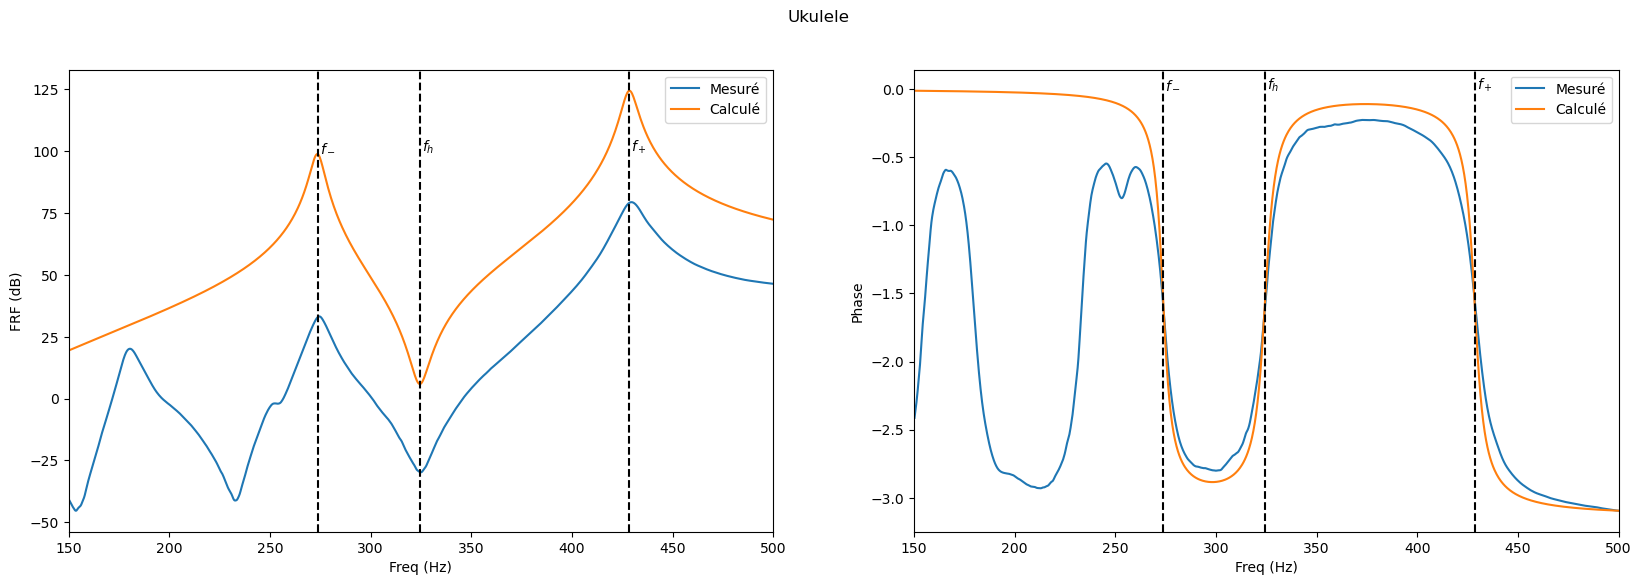

In [17]:
def modele_theorique(file="Guitare_2.mat",V=13e-3,majoute=28e-3,freqmin=50, freqmax = 500):
    #-----------------Calcul des paramètres-----------------------------------------------
    mu = 340 * 1.225 / V

    if file == "Guitare_2.mat":
        fmoins,fh,fplus = pics_normal[2],pics_normal[3],pics_normal[4]
        fmoinsa,fha,fplusa  = pics_28g[3],pics_28g[4],pics_28g[5]
    elif file =="Ukulele_2.mat":
        fmoins,fh,fplus = pics_ukulele[3],pics_ukulele[4],pics_ukulele[5]
        fmoinsa,fha,fplusa  = pics_20g_ukulele[3],pics_20g_ukulele[4],pics_20g_ukulele[5]
    else:
        print("Ca marche que pour Guitare_2.mat et Ukulele_2.mat :( ")
        return
    wmoins,wh,wplus = fmoins*2*np.pi,fh*2*np.pi,fplus*2*np.pi
    wmoinsa,wha,wplusa = fmoinsa*2*np.pi,fha*2*np.pi,fplusa*2*np.pi

    print(f"{fmoins=:.1f}Hz\t{fh=:.1f}Hz\t{fplus=:.1f}Hz")

    wp = np.sqrt(wplus**2 + wmoins**2 - wh**2)
    wph = (0.25*((2*wplus**2 - (wp**2 + wh**2))**2 - (wp**2 - wh**2)**2)) **(0.25)
    wa = wph**2 / wh
    wp0 = np.sqrt(wp**2 - wa**2)
    print(f"fp = {wp/(2*np.pi):.1f}Hz\tfph = {wph/(2*np.pi):.1f}Hz")
    print(f"fa = {wa/(2*np.pi):.1f}Hz\tfp0 = {wp0/(2*np.pi):.1f}Hz")
    print(f"{fmoinsa=:.1f}Hz\t{fha=:.1f}Hz\t{fplusa=:.1f}Hz")

    wpa = np.sqrt(wplusa**2 + wmoinsa**2 - wha**2)
    mp = (majoute/(wpa**2))/((1/(wpa**2)) - (1/wp**2))
    kp = wp0**2 * mp
    A = np.sqrt((wa**2 * mp)/mu)
    print(f"Masse de la table d'harmonie : {mp*1000:.1f} g\tRaideur de la table d'harmonie : {kp/1000:.2f} kN/m\tAire de piston équivalent : {A:.3f} m^2")

    df_moins, Q_moins = get_delta_f(file,fmoins,10) 
    df_plus, Q_plus = get_delta_f(file,fplus,10) 
    gamma_moins = df_moins*2*np.pi
    gamma_plus = df_plus*2*np.pi

    print(f"{Q_moins=:.2f}\t{Q_plus=:.2f}")
    print(f"{gamma_moins=:.2f}\t{gamma_plus=:.2f}")

    G = (wplus**2 - wmoins**2)/(wp**2-wa**2)
    M = np.array([[(G+1)/(2*G),(G-1)/(2*G)],[(G-1)/(2*G),(G+1)/(2*G)]])
    gamma_p,gamma_a=(np.linalg.inv(M)@np.array([[gamma_plus],[gamma_moins]])).flatten()
    print(f"{gamma_p=:.2f}\t{gamma_a=:.2f}")

    print(f'{A/mp=}')
    #-----------------Calcul de Z théorique----------------------------------------------

    w = np.linspace(freqmin*2*np.pi,freqmax*2*np.pi,1000)
    f_theo = w/(2*np.pi)
    D = (wp**2 - w**2 + 1j*w*gamma_p)*(wh**2-w**2+1j*w*gamma_a) - wph**4
    Z = -w**2 * ((wh**2-w**2) + 1j*w*gamma_p)/(mp*D)
    mag_theo = 20*np.log(np.abs(Z))
    phase_theo = np.mod(np.angle(Z),2*np.pi)-np.pi #Remettre en [-2pi;0]

    #------------------Plotting----------------

    data = load_mat(file)

    domaine = np.logical_and(data["freq"] < freqmax ,data["freq"] > freqmin )

    freq = data["freq"][domaine]
    mag = 20*np.log(np.abs(data["FRF"]))[domaine]
    phase = np.angle(data["FRF"])[domaine]

    plt.figure(figsize=(20,6))
    plt.subplot(1,2,1)
    plt.xlim([freqmin,freqmax])
    plt.plot(freq,mag,label = "Mesuré")
    plt.plot(f_theo,mag_theo,label="Calculé")
    for f, s in zip([fmoins, fplus, fh], ["$f_-$", "$f_+$", "$f_h$"]):
        plt.axvline(f, linestyle="--", color="black")
        plt.annotate(s, (f+1, 100))
    plt.xlabel("Freq (Hz)")
    plt.ylabel("FRF (dB)")
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlim([freqmin,freqmax])
    plt.plot(freq,phase,label = "Mesuré")
    plt.plot(f_theo,phase_theo,label="Calculé")
    for f, s in zip([fmoins, fplus, fh], ["$f_-$", "$f_+$", "$f_h$"]):
        plt.axvline(f, linestyle="--", color="black")
        plt.annotate(s, (f+1, 0))
    plt.xlabel("Freq (Hz)")
    plt.ylabel("Phase")
    plt.legend()

    plt.suptitle(file2text(file))
    plt.savefig(os.path.join("images",file2text(file)+"_comparaison_modele.png"))
    plt.show()

    return
    
modele_theorique("Guitare_2.mat",V=0.013,majoute=0.028,freqmin=50,freqmax=250)
modele_theorique("Ukulele_2.mat",V=0.008,majoute=0.020,freqmin=150,freqmax=500)
pass